In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
!unzip gdrive/MyDrive/EEE_485_Project/Data.zip > /dev/null

replace Data/test/adenocarcinoma/000005 (3).png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import os,glob
from PIL import Image

# Dataset Loader

In [ ]:
class Dataset_Loader:
    # Initialization
    def __init__(self, path_list, dim):
        self.path = path_list
        self.dim = dim
    
    # Flattening dimensions and putting reduced pixels into a list
    def flatten_pixels(self, list_pixels):
        return np.array(list_pixels).flatten().tolist()

    # Setting labels for classes
    def identify_label(self, img_path):
        if self.path.index(img_path) == 0:
            label = 0     # Normal
        elif self.path.index(img_path) == 1:
            label = 1     # Squamous Cell Carcinoma
        elif self.path.index(img_path) == 2:
            label = 2     # Large Cell Carcinoma
        elif self.path.index(img_path) == 3:
            label = 3     # Adenocarcinoma
        return label
    
    # Putting labels to the associated data points
    def update_labels(self, updated_label_list, identified_label):
        return updated_label_list.append(identified_label)
    
    # Full preprocessing
    def load_data_as_dataframe(self):
        # Initializing empty lists
        all_pixels=[]
        updated_label_list = []
        # Traversing through data
        for img_path in self.path:    
            os.chdir(img_path)
            for filename in glob.glob('*'):
                # Interacting with images
                if (filename.endswith('.png')) or (filename.endswith('.jpg')) or (filename.endswith('.jpeg')):
                    img_pixels = []
                    identified_label = self.identify_label(img_path)
                    updated_label_list.append(identified_label) 
                    # Coverting images to grayscale pixels
                    img = Image.open(filename).convert('L').resize((self.dim,self.dim),Image.ANTIALIAS)
                    img_pixels = list(img.getdata())
                    all_pixels.append((self.flatten_pixels(img_pixels)))
        return pd.DataFrame(all_pixels), updated_label_list

# Organizing Data

In [ ]:
train_path_list=["/content/Data/train/normal",
           "/content/Data/train/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa",
           "/content/Data/train/large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa",
           "/content/Data/train/adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib"]

train_data = Dataset_Loader(train_path_list,28)
df_train, train_labels = train_data.load_data_as_dataframe()

valid_path_list=["/content/Data/valid/normal",
           "/content/Data/valid/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa",
           "/content/Data/valid/large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa",
           "/content/Data/valid/adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib"]

valid_data = Dataset_Loader(valid_path_list,28)
df_valid, valid_labels = valid_data.load_data_as_dataframe()

test_path_list=["/content/Data/test/normal",
           "/content/Data/test/squamous.cell.carcinoma",
           "/content/Data/test/large.cell.carcinoma",
           "/content/Data/test/adenocarcinoma"]

test_data = Dataset_Loader(test_path_list,28)
df_test, test_labels = test_data.load_data_as_dataframe()

In [ ]:
df_train['Labels']= train_labels
print('\n', df_train)

df_valid['Labels']= valid_labels
print('\n', df_valid)

df_test['Labels']= test_labels
print('\n', df_test)

Train 
             0         1         2         3         4         5         6  \
0    0.179894  0.179894  0.179894  0.793651  0.793651  0.793651  0.915344   
1    0.003968  0.003968  0.003968  0.003968  0.003968  0.003968  0.003968   
2    0.004348  0.004348  0.004348  0.004348  0.004348  0.004348  0.008696   
3    0.004167  0.004167  0.004167  0.004167  0.004167  0.004167  0.058333   
4    0.004082  0.004082  0.004082  0.004082  0.004082  0.004082  0.032653   
..        ...       ...       ...       ...       ...       ...       ...   
695  0.006098  0.006098  0.006098  0.006098  0.006098  0.006098  0.006098   
696  0.006757  0.006757  0.006757  0.006757  0.006757  0.006757  0.006757   
697  0.007143  0.007143  0.007143  0.007143  0.007143  0.007143  0.007143   
698  0.006579  0.006579  0.006579  0.006579  0.006579  0.006579  0.006579   
699  0.006757  0.006757  0.006757  0.006757  0.006757  0.006757  0.006757   

            7         8         9  ...      2343      2344      234

In [ ]:
DTrain = df_train.to_numpy()

DValid = df_valid.to_numpy()

DTest = df_test.to_numpy()

In [ ]:
# Seperate Features (X) and Labels (Y)
trainX = np.delete(DTrain, -1, 1)
trainY = np.delete(DTrain, np.s_[0: -1], 1)
valX = np.delete(DValid, -1, 1)
valY = np.delete(DValid, np.s_[0: -1], 1)
testX = np.delete(DTest, -1, 1)
testY = np.delete(DTest, np.s_[0: -1], 1)

In [ ]:
# Conversion to int for easy usage
trainX = trainX.astype(int)
trainY = trainY.astype(int)
valX = valX.astype(int)
valY = valY.astype(int)
testX = testX.astype(int)
testY = testY.astype(int)

# PCA

## PCA Functions and Imports

In [ ]:
#importing libraries
import os
import sys
import cv2 as cv
import numpy as np
import plotly.io as pio
import plotly.graph_objs as go

from PIL import Image
from skimage import color
from plotly import subplots

In [ ]:
def covariance_matrix(X):
  X_mean_centered  = (X.T - np.mean(X,axis=1)).T
  X_cov = np.cov(X_mean_centered.T)
  return X_cov

In [ ]:
def eigenvalues(X):
  X_cov = covariance_matrix(X)
  l, u = np.linalg.eig(X_cov)
  l = np.real(l)
  u = np.real(u)
  eigen_d = dict(zip(l,u.T))
  eigen_s  = sorted(eigen_d)[::-1]
  return eigen_d, eigen_s

In [ ]:
def first_k_eigenvalues(X, k):
  eigen_d, eigen_s = eigenvalues(X)
  first_10_eigenvalues = eigen_s[:k]
  return first_10_eigenvalues

In [ ]:
def PVE(X, k):
  k_eigenvalues = first_k_eigenvalues(X,k)
  eigen_d, eigen_s = eigenvalues(X)
  first_10_eigenvectors = []
  for e in k_eigenvalues:
      first_10_eigenvectors.append(eigen_d[e])
  eigen_sum = np.sum(eigen_s)
  first_10_pve = k_eigenvalues/eigen_sum
  return first_10_eigenvectors, eigen_sum, first_10_pve

In [ ]:
def PCA_load_images(img_path, total, size = 64):
  X = []
  X_f = []
  count = 1
  for img in os.listdir(img_path):
      if count == total + 1:
          break
      sys.stdout.flush()
      img_array = cv.imread(os.path.join(img_path, img))
      img_pil = Image.fromarray(img_array)
      img_64x64 = np.array(img_pil.resize((size, size), Image.BILINEAR))
      X.append(img_64x64)
      img_array = img_64x64.reshape(4096,3)
      X_f.append(img_array)
      count += 1

  X_f = np.asarray(X_f)
  X_f.shape

  X_split = [np.squeeze(subarray) for subarray in np.dsplit(X_f, 3)]

  R = X_split[0]
  G = X_split[1]
  B = X_split[2]

  R_norm = ((R - np.amin(R))/(np.amax(R) - np.amin(R))).T
  G_norm = ((G - np.amin(G))/(np.amax(G) - np.amin(G))).T
  B_norm = ((B - np.amin(B))/(np.amax(B) - np.amin(B))).T

  return R_norm, G_norm, B_norm

In [ ]:
def PCA(X, reduced_dim = 25):
  first_eigenvectors, eigen_sum, first_pve = PVE(X, reduced_dim)
  eigen_d, eigen_s = eigenvalues(X)

  first_nparray = np.array(first_eigenvectors)
  
  print(first_pve*100)
  print("Total PVE:")
  print(np.sum(first_pve*100))
  
  return first_nparray

In [ ]:
def get_reduced_data(R_PC, G_PC, B_PC, total, reduced_dim = 25):
  R_PC_normalized = ((R_PC - np.amin(R_PC))/(np.amax(R_PC) - np.amin(R_PC)))
  G_PC_normalized = ((G_PC - np.amin(G_PC))/(np.amax(G_PC) - np.amin(G_PC)))
  B_PC_normalized = ((B_PC - np.amin(B_PC))/(np.amax(B_PC) - np.amin(B_PC)))
  
  RGB_PC = (np.stack((R_PC_normalized, G_PC_normalized, B_PC_normalized), axis=0)).reshape((3*total),reduced_dim)

  return RGB_PC

In [ ]:
def processingforplot(image) -> None:  # For image plots
    plt.figure()
    plt.imshow(image)

## PCA Training Split

### Class 0: Normal

In [ ]:
trn0_R, trn0_G, trn0_B = PCA_load_images('/content/Data/train/normal', total = 151)

print("\n For Red \n")
trn0_R_PC = (PCA(trn0_R)).T
print("\n For Green \n")
trn0_G_PC = (PCA(trn0_G)).T
print("\n For Blue \n")
trn0_B_PC = (PCA(trn0_B)).T

# Recombination
trn0_RGB_PC = get_reduced_data(trn0_R_PC, trn0_G_PC, trn0_B_PC, total = 151)


 For Red 

[33.35405843 11.45068538  8.48606828  7.58207289  5.55358362  4.81743675
  4.03768718  3.22411542  2.56674441  2.27444611  1.9011499   1.73256338
  1.54506355  1.32087153  1.22627654  1.14568482  0.91252984  0.80376375
  0.66708242  0.58998654  0.58516434  0.55862921  0.48823082  0.46062716
  0.36870251]
Total PVE:
97.65322479302134

 For Green 

[33.34063111 11.4508326   8.48619777  7.593991    5.55155594  4.82370523
  4.03283228  3.22274358  2.56465036  2.28007674  1.89992145  1.73482402
  1.54526344  1.32063136  1.22693435  1.14479156  0.91203752  0.8025092
  0.66727874  0.59023285  0.58579118  0.55835516  0.48857261  0.46039969
  0.36806717]
Total PVE:
97.65282690809904

 For Blue 

[33.33827562 11.44690292  8.483028    7.59693685  5.55789161  4.8163399
  4.03867681  3.22331869  2.56908916  2.27699827  1.90554668  1.73689382
  1.54287924  1.3200554   1.22422544  1.14553024  0.91181108  0.80184655
  0.66876928  0.59157936  0.58287337  0.55729416  0.48666258  0.46124693
 

### Class 1: Squamous Cell Carcinoma

In [ ]:
trn1_R, trn1_G, trn1_B = PCA_load_images('/content/Data/train/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa', total = 182)

print("\n For Red \n")
trn1_R_PC = (PCA(trn1_R)).T
print("\n For Green \n")
trn1_G_PC = (PCA(trn1_G)).T
print("\n For Blue \n")
trn1_B_PC = (PCA(trn1_B)).T

# Recombination
trn1_RGB_PC = get_reduced_data(trn1_R_PC, trn1_G_PC, trn1_B_PC, total = 182)


 For Red 

[21.84566103  9.60572091  7.15680443  5.69297947  5.19026738  4.05768992
  3.30710743  3.19027474  2.31311598  2.11095725  1.96839719  1.76789859
  1.58012218  1.39119391  1.35986594  1.1757108   1.05638529  1.01528237
  0.8908014   0.85161602  0.77200779  0.72493875  0.64994521  0.62867253
  0.58864796]
Total PVE:
80.89206448525901

 For Green 

[21.84566103  9.60572091  7.15680443  5.69297947  5.19026738  4.05768992
  3.30710743  3.19027474  2.31311598  2.11095725  1.96839719  1.76789859
  1.58012218  1.39119391  1.35986594  1.1757108   1.05638529  1.01528237
  0.8908014   0.85161602  0.77200779  0.72493875  0.64994521  0.62867253
  0.58864796]
Total PVE:
80.89206448525901

 For Blue 

[21.84566103  9.60572091  7.15680443  5.69297947  5.19026738  4.05768992
  3.30710743  3.19027474  2.31311598  2.11095725  1.96839719  1.76789859
  1.58012218  1.39119391  1.35986594  1.1757108   1.05638529  1.01528237
  0.8908014   0.85161602  0.77200779  0.72493875  0.64994521  0.62867253

### Class 2: Large Cell Carcinoma

In [ ]:
trn2_R, trn2_G, trn2_B = PCA_load_images('/content/Data/train/large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa', total = 131)

print("\n For Red \n")
trn2_R_PC = (PCA(trn2_R)).T
print("\n For Green \n")
trn2_G_PC = (PCA(trn2_G)).T
print("\n For Blue \n")
trn2_B_PC = (PCA(trn2_B)).T

# Recombination
trn2_RGB_PC = get_reduced_data(trn2_R_PC, trn2_G_PC, trn2_B_PC, total = 131)


 For Red 

[15.92514239  9.99513646  8.18046723  7.12284892  5.94214672  4.79701685
  3.32917297  3.0442208   2.62471394  2.52440508  2.43179131  1.87243674
  1.60554162  1.56702763  1.46129459  1.34925183  1.06288956  0.9981726
  0.98752567  0.93976409  0.90134388  0.83134972  0.72910372  0.71473939
  0.69046202]
Total PVE:
81.6279657146654

 For Green 

[15.92513692  9.99507477  8.18356138  7.12326715  5.94089932  4.79693265
  3.32924066  3.04422475  2.62359355  2.52455897  2.43182226  1.87239212
  1.60546909  1.56697473  1.4609746   1.34919186  1.06282993  0.99811015
  0.9874952   0.93974563  0.90132225  0.8312856   0.72913347  0.71476534
  0.69046452]
Total PVE:
81.62846685899767

 For Blue 

[15.92716281  9.99228868  8.14498176  7.11848449  5.95613     4.79442603
  3.32953182  3.04266044  2.64676382  2.5210393   2.4321691   1.87406281
  1.60684861  1.56759723  1.46525449  1.34981082  1.0624409   0.99850885
  0.98770673  0.94001254  0.90158478  0.83123824  0.72797713  0.7133059
  

### Class 3: Adenocarcinoma

In [ ]:
trn3_R, trn3_G, trn3_B = PCA_load_images('/content/Data/train/adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib', total = 236)

print("\n For Red \n")
trn3_R_PC = (PCA(trn3_R)).T
print("\n For Green \n")
trn3_G_PC = (PCA(trn3_G)).T
print("\n For Blue \n")
trn3_B_PC = (PCA(trn3_B)).T

# Recombination
trn3_RGB_PC = get_reduced_data(trn3_R_PC, trn3_G_PC, trn3_B_PC, total = 236)


 For Red 

[17.19159842 10.09794211  7.97515212  5.77692099  4.45228848  3.69401607
  3.52488923  2.6507238   2.45512007  2.00525853  1.86964159  1.69940547
  1.55660495  1.44196497  1.28725379  1.10861811  1.02751493  0.9602212
  0.93700107  0.89215714  0.81463837  0.77850787  0.73079502  0.68121974
  0.63068122]
Total PVE:
76.24013526381984

 For Green 

[17.19225517 10.09765366  7.9750698   5.77679547  4.45154122  3.69243596
  3.52440782  2.6507083   2.45513591  2.00531951  1.86963333  1.69922448
  1.55627178  1.44230085  1.28737832  1.10843691  1.02737832  0.96039917
  0.93700093  0.892527    0.81502481  0.7786063   0.73106042  0.68133233
  0.63076122]
Total PVE:
76.2386589550493

 For Blue 

[17.19221338 10.09767767  7.97507478  5.77679699  4.45158749  3.6925487
  3.52444295  2.65070928  2.45513544  2.00531804  1.86963095  1.69924176
  1.55629614  1.44228134  1.28737044  1.10844937  1.02738669  0.96038872
  0.93700166  0.89250152  0.81499932  0.77859982  0.73105105  0.68132436
  

## PCA Validation Split

### Class 0: Normal

In [ ]:
val0_R, val0_G, val0_B = PCA_load_images('/content/Data/valid/normal', total = 32)

print("\n For Red \n")
val0_R_PC = (PCA(val0_R)).T
print("\n For Green \n")
val0_G_PC = (PCA(val0_G)).T
print("\n For Blue \n")
val0_B_PC = (PCA(val0_B)).T

# Recombination
val0_RGB_PC = get_reduced_data(val0_R_PC, val0_G_PC, val0_B_PC, total = 32)


 For Red 

[3.02997082e+01 1.48885714e+01 1.03074632e+01 8.29424341e+00
 7.21047694e+00 4.60139396e+00 3.44976542e+00 3.21137863e+00
 2.54104900e+00 2.28322676e+00 1.91341305e+00 1.80758734e+00
 1.71425081e+00 1.47889903e+00 1.26896920e+00 1.19762013e+00
 1.00023683e+00 8.18289192e-01 7.72190356e-01 5.74247286e-01
 1.82499584e-01 1.13758765e-01 4.24980185e-02 1.92640680e-02
 5.89908278e-03]
Total PVE:
99.99689960331688

 For Green 

[3.02874352e+01 1.48876943e+01 1.03089595e+01 8.29536534e+00
 7.20919361e+00 4.60988769e+00 3.44997537e+00 3.21250454e+00
 2.54007296e+00 2.28431275e+00 1.91420901e+00 1.81161380e+00
 1.71277064e+00 1.47670079e+00 1.26838368e+00 1.19803687e+00
 1.00047237e+00 8.18484080e-01 7.72359040e-01 5.74300696e-01
 1.82544452e-01 1.13782218e-01 4.25543720e-02 1.92618308e-02
 5.90007207e-03]
Total PVE:
99.99677514402659

 For Blue 

[3.02781717e+01 1.48932678e+01 1.03145239e+01 8.29283111e+00
 7.20054414e+00 4.60842064e+00 3.44899753e+00 3.20994428e+00
 2.54331271e+00

### Class 1: Squamous Cell Carcinoma

In [ ]:
val1_R, val1_G, val1_B = PCA_load_images('/content/Data/valid/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa', total = 39)

print("\n For Red \n")
val1_R_PC = (PCA(val1_R)).T
print("\n For Green \n")
val1_G_PC = (PCA(val1_G)).T
print("\n For Blue \n")
val1_B_PC = (PCA(val1_B)).T

# Recombination
val1_RGB_PC = get_reduced_data(val1_R_PC, val1_G_PC, val1_B_PC, total = 39)


 For Red 

[19.73457202 11.16967249 10.53980224  8.01925526  6.65818251  4.51128935
  3.84182787  3.43673655  3.23988672  2.58588045  2.47943992  2.05851594
  1.89906813  1.73703806  1.58323008  1.39351805  1.32782849  1.24998354
  1.23601237  1.08802644  1.05235974  0.94893348  0.88413405  0.82151389
  0.76876337]
Total PVE:
94.26547102365959

 For Green 

[19.71447408 11.16363506 10.55097571  8.06852871  6.66573044  4.5178383
  3.82872189  3.43376685  3.23951886  2.58321189  2.47608125  2.05609175
  1.89431789  1.7356673   1.58199882  1.39245068  1.32634877  1.24876475
  1.2343841   1.08726755  1.05197702  0.94791313  0.88320136  0.8207456
  0.76782681]
Total PVE:
94.27143854304035

 For Blue 

[19.71297292 11.16358827 10.55043991  8.07633129  6.66615529  4.519102
  3.82778546  3.43212265  3.23787354  2.58322374  2.47615314  2.05573877
  1.89374767  1.735219    1.58162708  1.39252206  1.32621938  1.24831658
  1.23419789  1.08732095  1.05205398  0.94781936  0.88313321  0.82067766
  0

### Class 2: Large Cell Carcinoma

In [ ]:
val2_R, val2_G, val2_B = PCA_load_images('/content/Data/valid/large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa', total = 28)

print("\n For Red \n")
val2_R_PC = (PCA(val2_R)).T
print("\n For Green \n")
val2_G_PC = (PCA(val2_G)).T
print("\n For Blue \n")
val2_B_PC = (PCA(val2_B)).T

# Recombination
val2_RGB_PC = get_reduced_data(val2_R_PC, val2_G_PC, val2_B_PC, total = 28)


 For Red 

[21.82377776 14.86854814  8.5552612   7.31600754  6.7995879   5.32070332
  4.55123811  4.06285789  3.58406769  2.85554438  2.7047295   2.33829215
  2.20573753  1.63740837  1.57925278  1.49203935  1.32352523  1.22572781
  1.16391332  0.99087737  0.83475947  0.65006276  0.59862996  0.56312979
  0.48295519]
Total PVE:
99.5286345235554

 For Green 

[21.82377776 14.86854814  8.5552612   7.31600754  6.7995879   5.32070332
  4.55123811  4.06285789  3.58406769  2.85554438  2.7047295   2.33829215
  2.20573753  1.63740837  1.57925278  1.49203935  1.32352523  1.22572781
  1.16391332  0.99087737  0.83475947  0.65006276  0.59862996  0.56312979
  0.48295519]
Total PVE:
99.5286345235554

 For Blue 

[21.82377776 14.86854814  8.5552612   7.31600754  6.7995879   5.32070332
  4.55123811  4.06285789  3.58406769  2.85554438  2.7047295   2.33829215
  2.20573753  1.63740837  1.57925278  1.49203935  1.32352523  1.22572781
  1.16391332  0.99087737  0.83475947  0.65006276  0.59862996  0.56312979
 

### Class 3: Adenocarcinoma

In [ ]:
val3_R, val3_G, val3_B = PCA_load_images('/content/Data/valid/adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib', total = 51)

print("\n For Red \n")
val3_R_PC = (PCA(val3_R)).T
print("\n For Green \n")
val3_G_PC = (PCA(val3_G)).T
print("\n For Blue \n")
val3_B_PC = (PCA(val3_B)).T

# Recombination
val3_RGB_PC = get_reduced_data(val3_R_PC, val3_G_PC, val3_B_PC, total = 51)


 For Red 

[22.85198331 10.07915098  9.23583935  6.76447573  6.46764221  4.44988596
  4.10307755  3.21814114  2.78016961  2.56965369  2.28257299  1.92347413
  1.78881395  1.55682577  1.4893873   1.41720557  1.23097335  1.02450331
  0.99154699  0.89773495  0.85424027  0.7986916   0.74766845  0.73462376
  0.65056771]
Total PVE:
90.90884960503752

 For Green 

[22.85198331 10.07915098  9.23583935  6.76447573  6.46764221  4.44988596
  4.10307755  3.21814114  2.78016961  2.56965369  2.28257299  1.92347413
  1.78881395  1.55682577  1.4893873   1.41720557  1.23097335  1.02450331
  0.99154699  0.89773495  0.85424027  0.7986916   0.74766845  0.73462376
  0.65056771]
Total PVE:
90.90884960503752

 For Blue 

[22.85198331 10.07915098  9.23583935  6.76447573  6.46764221  4.44988596
  4.10307755  3.21814114  2.78016961  2.56965369  2.28257299  1.92347413
  1.78881395  1.55682577  1.4893873   1.41720557  1.23097335  1.02450331
  0.99154699  0.89773495  0.85424027  0.7986916   0.74766845  0.73462376

## PCA Testing Split

### Class 0: Normal

In [ ]:
tst0_R, tst0_G, tst0_B = PCA_load_images('/content/Data/test/normal', total = 32)

print("\n For Red \n")
tst0_R_PC = (PCA(tst0_R)).T
print("\n For Green \n")
tst0_G_PC = (PCA(tst0_G)).T
print("\n For Blue \n")
tst0_B_PC = (PCA(tst0_B)).T

# Recombination
tst0_RGB_PC = get_reduced_data(tst0_R_PC, tst0_G_PC, tst0_B_PC, total = 32)


 For Red 

[3.39317391e+01 1.52218053e+01 8.53422922e+00 7.66474322e+00
 6.30945968e+00 5.63138800e+00 4.23101612e+00 3.43290613e+00
 2.75146209e+00 2.01542143e+00 1.80423286e+00 1.61079859e+00
 1.46159432e+00 1.22870355e+00 1.15613704e+00 1.11301014e+00
 7.92317146e-01 6.75752305e-01 3.75136756e-01 2.64347657e-02
 1.83524784e-02 1.16518247e-02 1.39363206e-03 2.78373411e-04
 3.58731525e-05]
Total PVE:
99.99999999999999

 For Green 

[3.39232770e+01 1.52210653e+01 8.53690562e+00 7.67126006e+00
 6.31143284e+00 5.63175416e+00 4.22863804e+00 3.43373834e+00
 2.75009534e+00 2.01669113e+00 1.80335449e+00 1.61064668e+00
 1.46197923e+00 1.22878808e+00 1.15648086e+00 1.11224346e+00
 7.92526499e-01 6.75834173e-01 3.75138190e-01 2.64359241e-02
 1.83539450e-02 1.16526285e-02 1.39372702e-03 2.78374154e-04
 3.58744952e-05]
Total PVE:
99.99999999999999

 For Blue 

[3.39293958e+01 1.52204650e+01 8.53327694e+00 7.66424079e+00
 6.30930570e+00 5.63257599e+00 4.23174793e+00 3.43296835e+00
 2.75236874e+00

### Class 1: Squamous Cell Carcinoma

In [ ]:
tst1_R, tst1_G, tst1_B = PCA_load_images('/content/Data/test/squamous.cell.carcinoma', total = 39)

print("\n For Red \n")
tst1_R_PC = (PCA(tst1_R)).T
print("\n For Green \n")
tst1_G_PC = (PCA(tst1_G)).T
print("\n For Blue \n")
tst1_B_PC = (PCA(tst1_B)).T

# Recombination
tst1_RGB_PC = get_reduced_data(tst1_R_PC, tst1_G_PC, tst1_B_PC, total = 39)


 For Red 

[24.69399362 13.10451695 10.06719573  7.09060791  5.32638369  4.49650784
  4.36628257  3.48203903  2.85905933  2.15451633  1.92523934  1.82486015
  1.74408156  1.64767952  1.45753342  1.3263145   1.14452561  1.07570352
  0.97474549  0.94833118  0.88378928  0.84965935  0.73953468  0.68070261
  0.63257665]
Total PVE:
95.49637985063929

 For Green 

[24.69399362 13.10451695 10.06719573  7.09060791  5.32638369  4.49650784
  4.36628257  3.48203903  2.85905933  2.15451633  1.92523934  1.82486015
  1.74408156  1.64767952  1.45753342  1.3263145   1.14452561  1.07570352
  0.97474549  0.94833118  0.88378928  0.84965935  0.73953468  0.68070261
  0.63257665]
Total PVE:
95.49637985063929

 For Blue 

[24.69399362 13.10451695 10.06719573  7.09060791  5.32638369  4.49650784
  4.36628257  3.48203903  2.85905933  2.15451633  1.92523934  1.82486015
  1.74408156  1.64767952  1.45753342  1.3263145   1.14452561  1.07570352
  0.97474549  0.94833118  0.88378928  0.84965935  0.73953468  0.68070261

### Class 2: Large Cell Carcinoma

In [ ]:
tst2_R, tst2_G, tst2_B = PCA_load_images('/content/Data/test/large.cell.carcinoma', total = 28)

print("\n For Red \n")
tst2_R_PC = (PCA(tst2_R)).T
print("\n For Green \n")
tst2_G_PC = (PCA(tst2_G)).T
print("\n For Blue \n")
tst2_B_PC = (PCA(tst2_B)).T

# Recombination
tst2_RGB_PC = get_reduced_data(tst2_R_PC, tst2_G_PC, tst2_B_PC, total = 28)


 For Red 

[18.86385927 15.10073746 12.04685214  9.48622021  7.66231348  6.61301638
  4.08268414  3.47811689  2.93460272  2.51393013  2.12505926  1.83695913
  1.7217617   1.53869597  1.3220928   1.16225222  1.08140583  1.01509419
  0.88279683  0.85726102  0.78511477  0.66143744  0.61541979  0.547106
  0.41438951]
Total PVE:
99.34917929241999

 For Green 

[18.86385927 15.10073746 12.04685214  9.48622021  7.66231348  6.61301638
  4.08268414  3.47811689  2.93460272  2.51393013  2.12505926  1.83695913
  1.7217617   1.53869597  1.3220928   1.16225222  1.08140583  1.01509419
  0.88279683  0.85726102  0.78511477  0.66143744  0.61541979  0.547106
  0.41438951]
Total PVE:
99.34917929241999

 For Blue 

[18.86385927 15.10073746 12.04685214  9.48622021  7.66231348  6.61301638
  4.08268414  3.47811689  2.93460272  2.51393013  2.12505926  1.83695913
  1.7217617   1.53869597  1.3220928   1.16225222  1.08140583  1.01509419
  0.88279683  0.85726102  0.78511477  0.66143744  0.61541979  0.547106
  0.4

### Class 3: Adenocarcinoma

In [ ]:
tst3_R, tst3_G, tst3_B = PCA_load_images('/content/Data/test/adenocarcinoma', total = 51)

print("\n For Red \n")
tst3_R_PC = (PCA(tst3_R)).T
print("\n For Green \n")
tst3_G_PC = (PCA(tst3_G)).T
print("\n For Blue \n")
tst3_B_PC = (PCA(tst3_B)).T

# Recombination
tst3_RGB_PC = get_reduced_data(tst3_R_PC, tst3_G_PC, tst3_B_PC, total = 51)


 For Red 

[26.03540548  8.96470986  7.63608332  6.71906071  5.78388161  4.30335102
  3.85377312  3.22866209  2.59906035  2.3667434   2.16507994  1.8762484
  1.77440091  1.72714064  1.48604059  1.35532677  1.27770788  1.1789161
  1.04460643  0.94437063  0.87928808  0.82462724  0.8071153   0.77733992
  0.73971465]
Total PVE:
90.34865444482301

 For Green 

[26.04227975  8.96211189  7.63521179  6.71085246  5.78286363  4.30350468
  3.85380987  3.22905644  2.59890398  2.36727716  2.16488774  1.87850031
  1.77733126  1.7258226   1.485463    1.35485558  1.27756419  1.17874551
  1.04665155  0.94400772  0.87978705  0.82589722  0.80784357  0.7768264
  0.74050676]
Total PVE:
90.35056211648755

 For Blue 

[26.04098486  8.96248759  7.63529051  6.71231451  5.78297725  4.30343539
  3.85376799  3.22902469  2.59889367  2.36717032  2.16489503  1.87830014
  1.77691211  1.72610423  1.48562116  1.35491032  1.27759278  1.17876633
  1.04634521  0.94405995  0.87969863  0.82577702  0.80772762  0.77690208
  

# Rearranging Data

In [ ]:
def new_data(D0_RGB_PC, D1_RGB_PC, D2_RGB_PC, D3_RGB_PC):
  return np.vstack((D0_RGB_PC, D1_RGB_PC, D2_RGB_PC, D3_RGB_PC))

In [ ]:
def new_class_labels(Dx_RGB_PC, label):
  Y = []
  for x in Dx_RGB_PC:
    Y.append(label)
  Y = np.asarray(Y)

  return Y

In [ ]:
def new_labels(D0_Y, D1_Y, D2_Y, D3_Y):
  return np.concatenate((D0_Y, D1_Y, D2_Y, D3_Y))

In [ ]:
# PCA Reduced Dataset with Colour Channel Information
trainPCX = new_data(trn0_RGB_PC, trn1_RGB_PC, trn2_RGB_PC, trn3_RGB_PC)
valPCX = new_data(val0_RGB_PC, val1_RGB_PC, val2_RGB_PC, val3_RGB_PC)
testPCX = new_data(tst0_RGB_PC, tst1_RGB_PC, tst2_RGB_PC, tst3_RGB_PC)

In [ ]:
# Per Class Labels for Colour Channel Enhanced Data
trn0_Y = new_class_labels(trn0_RGB_PC, 0)
trn1_Y = new_class_labels(trn1_RGB_PC, 1)
trn2_Y = new_class_labels(trn2_RGB_PC, 2)
trn3_Y = new_class_labels(trn3_RGB_PC, 3)

val0_Y = new_class_labels(val0_RGB_PC, 0)
val1_Y = new_class_labels(val1_RGB_PC, 1)
val2_Y = new_class_labels(val2_RGB_PC, 2)
val3_Y = new_class_labels(val3_RGB_PC, 3)

tst0_Y = new_class_labels(tst0_RGB_PC, 0)
tst1_Y = new_class_labels(tst1_RGB_PC, 1)
tst2_Y = new_class_labels(tst2_RGB_PC, 2)
tst3_Y = new_class_labels(tst3_RGB_PC, 3)

In [ ]:
# PCA Reduced Labels with Colour Channel Information
trainPCY = new_labels(trn0_Y, trn1_Y, trn2_Y, trn3_Y)
valPCY = new_labels(val0_Y, val1_Y, val2_Y, val3_Y)
testPCY = new_labels(tst0_Y, tst1_Y, tst2_Y, tst3_Y)

# One-vs-All Logistic Regression

In [ ]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [ ]:
# Log loss
def cost(theta, x, y):
    h = sigmoid(x @ theta)
    m = len(y)
    cost = 1 / m * np.sum(-y * np.log(h) - (1 - y) * np.log(1 - h))
    grad = 1 / m * ((y - h) @ x)
    return cost, grad

In [ ]:
def fit(x, y, max_iter=10000, alpha=0.1):
    # Initializing
    x = np.insert(x, 0, 1, axis=1)
    thetas = []
    classes = np.unique(y)
    costs = np.zeros(max_iter)

    # Going class-wise becasue 1vA LR forms pairs for classes against the rest to solve in binary
    for c in classes:
        # one vs. all binary classification
        binary_y = np.where(y == c, 1, 0)
        # weights initialized as zeros
        theta = np.zeros(x.shape[1])
        # Actual run for epochs
        for epoch in range(max_iter):
            costs[epoch], grad = cost(theta, x, binary_y)
            theta += alpha * grad    
        # Weights update
        thetas.append(theta)
    return thetas, classes, costs

In [ ]:
def predict(classes, thetas, x):
    x = np.insert(x, 0, 1, axis=1)
    # Matrix multiplication and sigmoid activation to get predictions
    preds = [np.argmax([sigmoid(xi @ theta) for theta in thetas]) for xi in x]
    # Getting predictions
    return [classes[p] for p in preds]

In [ ]:
def score(classes, theta, x, y):
    # Checking predictions and getting accuracy
    return (predict(classes, theta, x) == y).mean()

In [ ]:
np.random.seed(34)

Finding Optimal Number of Epochs


 Validating with learning rate 0.1, and with 2500 epochs: 



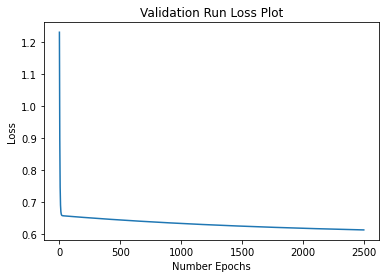


 Validating with learning rate 0.1, and with 5000 epochs: 



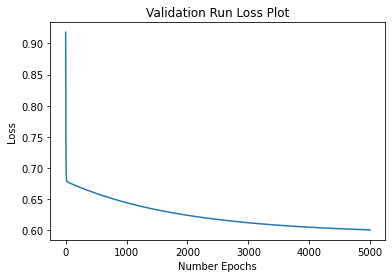


 Validating with learning rate 0.1, and with 7500 epochs: 



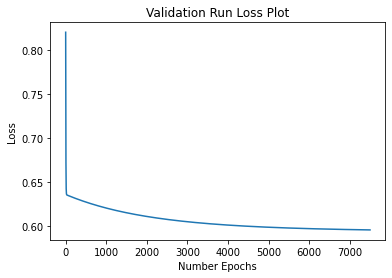


 Validating with learning rate 0.1, and with 10000 epochs: 



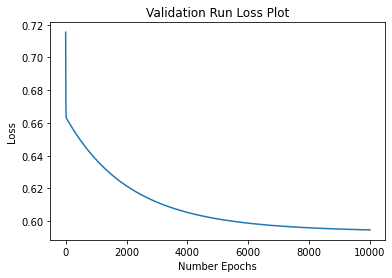

In [ ]:
for epoch in range(2500, 10001, 2500):
  print("\n Validating with learning rate 0.1, and with", epoch, "epochs: \n")

  thetas, classes, costs = fit(trainPCX[:, 2:], trainPCY, max_iter=epoch, alpha=0.1)
  plt.plot(costs)
  plt.title("Validation Run Loss Plot")
  plt.xlabel('Number Epochs'); plt.ylabel('Loss');
  plt.show()

Finding Optimal Learning Rate


 Validating with learning rate 0.1 and with 10000 epochs 



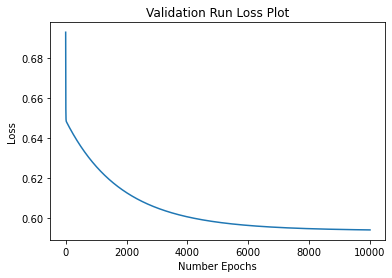


 Validating with learning rate 0.010000000000000002 and with 10000 epochs 



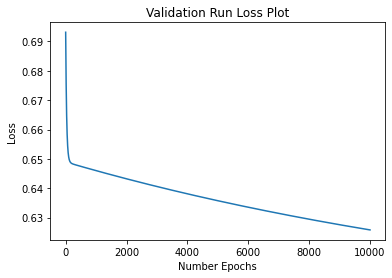


 Validating with learning rate 0.0010000000000000002 and with 10000 epochs 



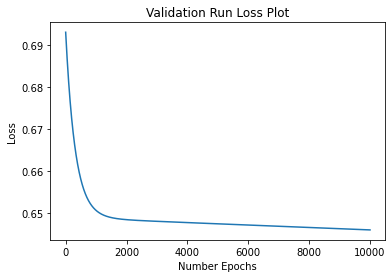


 Validating with learning rate 0.00010000000000000003 and with 10000 epochs 



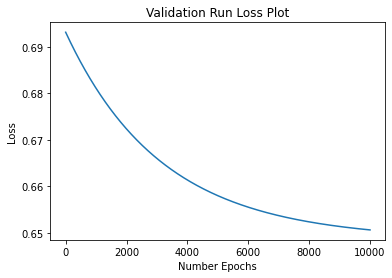

In [ ]:
lr = 0.1
while (lr > 0.0001):
  print("\n Validating with learning rate", lr, "and with 10000 epochs \n")

  thetas, classes, costs = fit(trainPCX[:, 2:], trainPCY, max_iter=10000, alpha=lr)
  plt.plot(costs)
  plt.title("Validation Run Loss Plot")
  plt.xlabel('Number Epochs'); plt.ylabel('Loss');
  plt.show()

  lr *= 10**-1

In [ ]:
thetas, classes, costs = fit(trainPCX, trainPCY, max_iter=10000, alpha=0.1)
print("Train Accuracy:", score(classes, thetas, trainPCX, trainPCY)*100)
print("Validation Accuracy:", score(classes, thetas, valPCX, valPCY)*100)

Train Accuracy: 54.285714285714285
Validation Accuracy: 39.111111111111114


In [ ]:
thetas, classes, costs = fit(trainPCX, trainPCY, max_iter=10000, alpha=0.1)
print("Train Accuracy:", score(classes, thetas, trainPCX, trainPCY)*100)
print("Test Accuracy:", score(classes, thetas, testPCX, testPCY)*100)

Train Accuracy: 54.285714285714285
Test Accuracy: 35.77777777777777


# kNN

In [ ]:
def euclidean_dist(x1, x2):
    d = np.square(x1 - x2)  # (x1-x2)**2 for every point in the vectors
    d = np.sum(d)           # adds all values
    d = np.sqrt(d)
    return d

In [ ]:
def distance_from_all_training(testP):
    dist_array = np.array([])
    for trainP in trainPCX:
        dist = euclidean_dist(testP, trainP)
        dist_array = np.append(dist_array, dist)
    return dist_array

In [ ]:
def KNNClassifier(trainX, trainY, testY, k = 9):
    predictions = np.array([])
    trainY = trainY.reshape(-1,1)
    for test_point in testY:    # iterating through every test data point
        dist_array = distance_from_all_training(test_point).reshape(-1,1)   # calculating distance from every training data instance
        neighbors = np.concatenate((dist_array, trainY), axis = 1)
        neighbors_sorted = neighbors[neighbors[:, 0].argsort()]     # sorting training points on the basis of distance
        k_neighbors = neighbors_sorted[:k]    # select k-nearest neighbors
        frequency = np.unique(k_neighbors[:, 1], return_counts=True)
        target_class = frequency[0][frequency[1].argmax()]    # selects label with highest frequency
        predictions = np.append(predictions, target_class)

    return predictions

In [ ]:
def accuracy(y_test, y_pred):
    total_correct = 0
    for i in range(len(y_test)):
        if int(y_test[i]) == int(y_pred[i]):  # Compares labels for accuracy
            total_correct += 1
    acc = total_correct/len(y_test)
    return acc

In [ ]:
def kNN_run(trainingX, trainingY, testingX, testingY, k):
  dist_array = distance_from_all_training(testingX[0])
  test_predictions = KNNClassifier(trainingX, trainingY, testingX, k)
  acc = accuracy(testingY, test_predictions)
  print('kNN accuracy =', acc*100, ', for k =', k)
  return acc*100

In [ ]:
def knn_val_run(trainingX, trainingY, testingX, testingY, max_k = 25):
  val_acc = []
  for k in range(max_k):
    k += 1
    k_val_acc = kNN_run(trainingX, trainingY, testingX, testingY, k)
    val_acc.append(k_val_acc)
  best_acc = max(val_acc)
  best_k = val_acc.index(best_acc) + 1
  print("\n Best kNN accuracy =", best_acc, ", for k =", best_k)
  return val_acc, best_k

Validation Runs using k = [1,25]

In [ ]:
val_acc, best_k = knn_val_run(trainPCX, trainPCY, valPCX, valPCY)

kNN accuracy = 32.88888888888889 , for k = 1
kNN accuracy = 33.33333333333333 , for k = 2
kNN accuracy = 33.55555555555556 , for k = 3
kNN accuracy = 32.666666666666664 , for k = 4
kNN accuracy = 34.66666666666667 , for k = 5
kNN accuracy = 33.55555555555556 , for k = 6
kNN accuracy = 33.77777777777778 , for k = 7
kNN accuracy = 35.11111111111111 , for k = 8
kNN accuracy = 35.77777777777777 , for k = 9
kNN accuracy = 33.55555555555556 , for k = 10
kNN accuracy = 34.44444444444444 , for k = 11
kNN accuracy = 33.33333333333333 , for k = 12
kNN accuracy = 32.22222222222222 , for k = 13
kNN accuracy = 33.33333333333333 , for k = 14
kNN accuracy = 33.33333333333333 , for k = 15
kNN accuracy = 32.0 , for k = 16
kNN accuracy = 34.44444444444444 , for k = 17
kNN accuracy = 33.111111111111114 , for k = 18
kNN accuracy = 33.33333333333333 , for k = 19
kNN accuracy = 32.0 , for k = 20
kNN accuracy = 31.333333333333336 , for k = 21
kNN accuracy = 32.22222222222222 , for k = 22
kNN accuracy = 32.88

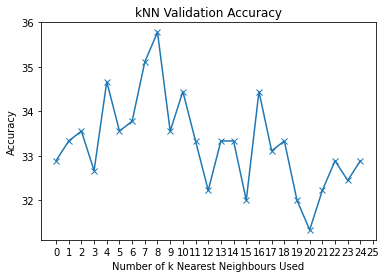

In [ ]:
plt.plot(val_acc, marker='x')
plt.xticks(range(0,len(val_acc)+1, 1))
plt.ylabel('Accuracy')
plt.xlabel('Number of k Nearest Neighbours Used') 
plt.title("kNN Validation Accuracy")
plt.show()

Testing Run with best k = 9

In [ ]:
kNN_test_acc = kNN_run(trainPCX, trainPCY, valPCX, valPCY, best_k)

kNN accuracy = 35.77777777777777 , for k = 9


# CNN

In [ ]:
import numpy as np

class ConvolutionLayer:
    def __init__(self, kernel_num, kernel_size):
        """
        Constructor takes as input the number of kernels and their size. I assume only squared filters of size kernel_size x kernel_size
        """
        self.kernel_num = kernel_num
        self.kernel_size = kernel_size
        # Generate random filters of shape (kernel_num, kernel_size, kernel_size). Divide by kernel_size^2 for weight normalization
        self.kernels = np.random.randn(kernel_num, kernel_size, kernel_size) / (kernel_size**2)

    def patches_generator(self, image):
        """
        Divide the input image in patches to be used during convolution.
        Yields the tuples containing the patches and their coordinates.
        """
        # Extract image height and width
        image_h, image_w = image.shape
        self.image = image
        # The number of patches, given a fxf filter is h-f+1 for height and w-f+1 for width
        for h in range(image_h-self.kernel_size+1):
            for w in range(image_w-self.kernel_size+1):
                patch = image[h:(h+self.kernel_size), w:(w+self.kernel_size)]
                yield patch, h, w
    
    def forward_prop(self, image):
        """
        Perform forward propagation for the convolutional layer.
        """
        # Extract image height and width
        image_h, image_w = image.shape
        # Initialize the convolution output volume of the correct size
        convolution_output = np.zeros((image_h-self.kernel_size+1, image_w-self.kernel_size+1, self.kernel_num))
        # Unpack the generator
        for patch, h, w in self.patches_generator(image):
            # Perform convolution for each patch
            convolution_output[h,w] = np.sum(patch*self.kernels, axis=(1,2))
        return convolution_output
    
    def back_prop(self, dE_dY, alpha):
        """
        Takes the gradient of the loss function with respect to the output and computes the gradients of the loss function with respect
        to the kernels' weights.
        dE_dY comes from the following layer, typically max pooling layer.
        It updates the kernels' weights
        """
        # Initialize gradient of the loss function with respect to the kernel weights
        dE_dk = np.zeros(self.kernels.shape)
        for patch, h, w in self.patches_generator(self.image):
            for f in range(self.kernel_num):
                dE_dk[f] += patch * dE_dY[h, w, f]
        # Update the parameters
        self.kernels -= alpha*dE_dk
        return dE_dk

class MaxPoolingLayer:
    def __init__(self, kernel_size):
        """
        Constructor takes as input the size of the kernel
        """
        self.kernel_size = kernel_size

    def patches_generator(self, image):
        """
        Divide the input image in patches to be used during pooling.
        Yields the tuples containing the patches and their coordinates.
        """
        # Compute the ouput size
        output_h = image.shape[0] // self.kernel_size
        output_w = image.shape[1] // self.kernel_size
        self.image = image

        for h in range(output_h):
            for w in range(output_w):
                patch = image[(h*self.kernel_size):(h*self.kernel_size+self.kernel_size), (w*self.kernel_size):(w*self.kernel_size+self.kernel_size)]
                yield patch, h, w

    def forward_prop(self, image):
        image_h, image_w, num_kernels = image.shape
        max_pooling_output = np.zeros((image_h//self.kernel_size, image_w//self.kernel_size, num_kernels))
        for patch, h, w in self.patches_generator(image):
            max_pooling_output[h,w] = np.amax(patch, axis=(0,1))
        return max_pooling_output

    def back_prop(self, dE_dY):
        """
        Takes the gradient of the loss function with respect to the output and computes the gradients of the loss function with respect
        to the kernels' weights.
        dE_dY comes from the following layer, typically softmax.
        There are no weights to update, but the output is needed to update the weights of the convolutional layer.
        """
        dE_dk = np.zeros(self.image.shape)
        for patch,h,w in self.patches_generator(self.image):
            image_h, image_w, num_kernels = patch.shape
            max_val = np.amax(patch, axis=(0,1))

            for idx_h in range(image_h):
                for idx_w in range(image_w):
                    for idx_k in range(num_kernels):
                        if patch[idx_h,idx_w,idx_k] == max_val[idx_k]:
                            dE_dk[h*self.kernel_size+idx_h, w*self.kernel_size+idx_w, idx_k] = dE_dY[h,w,idx_k]
            return dE_dk

class SoftmaxLayer:
    """
    Takes the volume coming from convolutional & pooling layers. It flattens it and it uses it in the next layers.
    """
    def __init__(self, input_units, output_units):
        # Initiallize weights and biases
        self.weight = np.random.randn(input_units, output_units)/input_units
        self.bias = np.zeros(output_units)

    def forward_prop(self, image):
        self.original_shape = image.shape # stored for backprop
        # Flatten the image
        image_flattened = image.flatten()
        self.flattened_input = image_flattened # stored for backprop
        # Perform matrix multiplication and add bias
        first_output = np.dot(image_flattened, self.weight) + self.bias
        self.output = first_output
        # Apply softmax activation
        softmax_output = np.exp(first_output) / np.sum(np.exp(first_output), axis=0)
        return softmax_output

    def back_prop(self, dE_dY, alpha):
        for i, gradient in enumerate(dE_dY):
            if gradient == 0:
                continue
            transformation_eq = np.exp(self.output)
            S_total = np.sum(transformation_eq)

            # Compute gradients with respect to output (Z)
            dY_dZ = -transformation_eq[i]*transformation_eq / (S_total**2)
            dY_dZ[i] = transformation_eq[i]*(S_total - transformation_eq[i]) / (S_total**2)

            # Compute gradients of output Z with respect to weight, bias, input
            dZ_dw = self.flattened_input
            dZ_db = 1
            dZ_dX = self.weight

            # Gradient of loss with respect ot output
            dE_dZ = gradient * dY_dZ

            # Gradient of loss with respect to weight, bias, input
            dE_dw = dZ_dw[np.newaxis].T @ dE_dZ[np.newaxis]
            dE_db = dE_dZ * dZ_db
            dE_dX = dZ_dX @ dE_dZ

            # Update parameters
            self.weight -= alpha*dE_dw
            self.bias -= alpha*dE_db

            return dE_dX.reshape(self.original_shape)

def CNN_forward(image, label, layers):
    image = ((image - np.amin(image))/(np.amax(image) - np.amin(image)))
    output = image
    for layer in layers:
        output = layer.forward_prop(output)
    # Compute loss (cross-entropy) and accuracy
    loss = -np.log(output[label])
    accuracy = 1 if np.argmax(output) == label else 0
    return output, loss, accuracy

def CNN_backprop(gradient, layers, alpha=0.05):
    grad_back = gradient
    for layer in layers[::-1]:
        if type(layer) in [ConvolutionLayer, SoftmaxLayer]:
            grad_back = layer.back_prop(grad_back, alpha)
        elif type(layer) == MaxPoolingLayer:
            grad_back = layer.back_prop(grad_back)
    return grad_back


def CNN_training(image, label, layers, alpha=0.05):
    # Forward step
    output, loss, accuracy = CNN_forward(image, label, layers)

    # Initial gradient with of length 4 because we have 4 outputs
    gradient = np.zeros(4)
    gradient[label] = -1/output[label]

    # Backprop step
    gradient_back = CNN_backprop(gradient, layers, alpha)

    return loss, accuracy

In [ ]:
import numpy as np
from matplotlib import pyplot as plt


def train_main_method(alpha):
    
    train_loss = []
    train_acc = []
    
    global trainX
    global trainY

    # Define the network
    layers = [
    ConvolutionLayer(16,3), # layer with 16 3x3 filters, output (62,62,16)
    MaxPoolingLayer(2), # pooling layer 2x2, output (31,31,16)
    SoftmaxLayer(31*31*16, 4) # softmax layer with 31*31*16 input and 4 outputs
    ] 
    print("================================================")
    print("Starting Training for learning rate: ", alpha)
    print("================================================")
    
    for epoch in range(4):
        print('Epoch {} ->'.format(epoch+1))
        # Shuffle training data
        permutation = np.random.permutation(len(trainX))
        trainX = trainX[permutation]
        trainY = trainY[permutation]
        # Training the CNN
        loss = 0
        accuracy = 0
        for i, (image, label) in enumerate(zip(trainX, trainY)):
            label = label[0]
            image = image.reshape(64, 64)
            
            if i>0 and i % 100 == 0: # Every 100 instance print and restart loss and accuracy
                print("Step {}. For the last 100 steps: average loss {}, accuracy {}".format(i+1, loss/100, accuracy))
                train_loss.append(loss)
                train_acc.append(accuracy) 
                loss = 0
                accuracy = 0
                
            loss_1, accuracy_1 = CNN_training(image, label, layers, alpha)
            loss += loss_1
            accuracy += accuracy_1
            
        plt.figure()    
        plt.xlabel("Per 100 Steps")
        plt.ylabel("Loss")
        plt.legend
        plt.title("Loss Vs Epochs")
        plt.plot(train_loss)
        plt.show

        plt.figure()
        plt.xlabel("Per 100 Steps")
        plt.ylabel("Accuracy")
        plt.legend
        plt.title("Accuracy vs Epochs")
        plt.plot(train_acc)
        plt.show()
        
        train_loss.clear()
        train_acc.clear() 

In [ ]:
def validate_cnn(alpha):
    accuracy = 0
    test_loss = []
    test_acc = []
    
    train_main_method(alpha)
    
    layers = [
    ConvolutionLayer(16,3), # layer with 16 3x3 filters, output (62,62,16)
    MaxPoolingLayer(2), # pooling layer 2x2, output (31,31,16)
    SoftmaxLayer(31*31*16, 4) # softmax layer with 31*31*16 input and 4 outputs
    ] 
    
    print("================================================")
    print("Starting Validation for learning rate: ", alpha)
    print("================================================")
    
    for i, (image, label) in enumerate(zip(valX, valY)):
        label = label[0]
        image = image.reshape(64,64)
        _ , loss, acc = CNN_forward(image, label, layers)
        
        if i>0 and i % 24 == 0: # Every 24 instance print and restart loss and accuracy
            print("Step {}. For the last 24 steps: average loss {}, accuracy {}".format(i+1, loss/24, accuracy))

        test_loss.append(loss)
        accuracy += acc
        test_acc.append(accuracy)
        
    plt.figure()
    plt.xlabel("Steps")
    plt.ylabel("Accuracy")
    plt.plot(test_acc)
    plt.show()
    
    plt.figure()
    plt.xlabel("Steps")
    plt.ylabel("loss")
    plt.legend()
    plt.plot(test_loss)
    plt.show()

Starting Training for learning rate:  0.0001
Epoch 1 ->
Step 101. For the last 100 steps: average loss 1.3397881780563257, accuracy 43
Step 201. For the last 100 steps: average loss 1.3837009266654356, accuracy 26
Step 301. For the last 100 steps: average loss 1.3260788819303557, accuracy 33
Step 401. For the last 100 steps: average loss 1.3116263970357653, accuracy 43
Step 501. For the last 100 steps: average loss 1.2857805037535825, accuracy 45
Step 601. For the last 100 steps: average loss 1.2527069615911488, accuracy 47


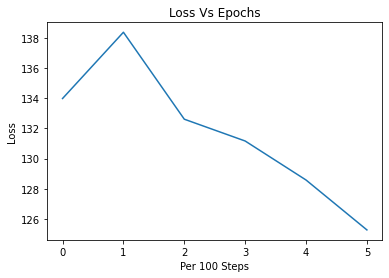

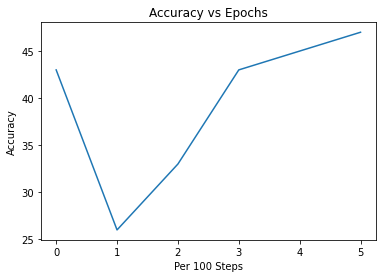

Epoch 2 ->
Step 101. For the last 100 steps: average loss 1.2850106527105054, accuracy 39
Step 201. For the last 100 steps: average loss 1.202890251030957, accuracy 48
Step 301. For the last 100 steps: average loss 1.248812905261675, accuracy 43
Step 401. For the last 100 steps: average loss 1.174826378812524, accuracy 50
Step 501. For the last 100 steps: average loss 1.1793805380817188, accuracy 53
Step 601. For the last 100 steps: average loss 1.2197674899427193, accuracy 49


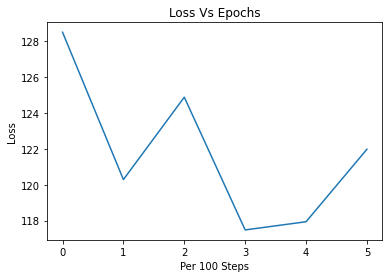

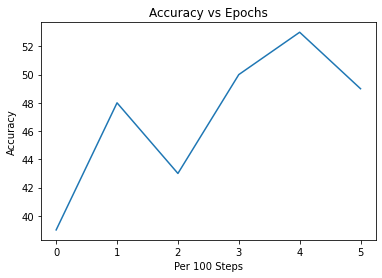

Epoch 3 ->
Step 101. For the last 100 steps: average loss 1.1475280536410053, accuracy 53
Step 201. For the last 100 steps: average loss 1.2344867447181658, accuracy 38
Step 301. For the last 100 steps: average loss 1.1688118002675416, accuracy 49
Step 401. For the last 100 steps: average loss 1.15991189660753, accuracy 47
Step 501. For the last 100 steps: average loss 1.089546013487733, accuracy 56
Step 601. For the last 100 steps: average loss 1.1320505868210131, accuracy 49


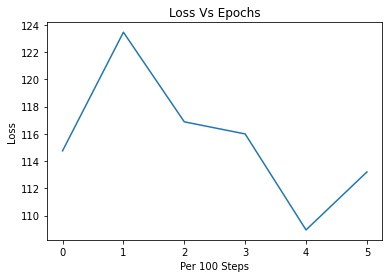

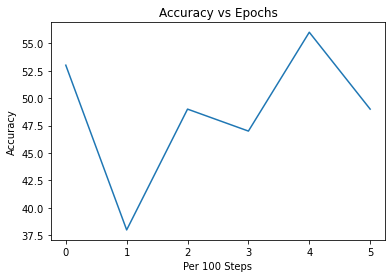

Epoch 4 ->
Step 101. For the last 100 steps: average loss 1.1672802050833107, accuracy 48
Step 201. For the last 100 steps: average loss 1.1379021720634956, accuracy 50
Step 301. For the last 100 steps: average loss 1.0857245556266732, accuracy 50
Step 401. For the last 100 steps: average loss 1.1036509072600886, accuracy 54
Step 501. For the last 100 steps: average loss 1.0715151307992412, accuracy 52
Step 601. For the last 100 steps: average loss 1.142806442475733, accuracy 48


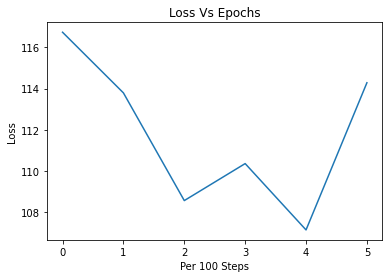

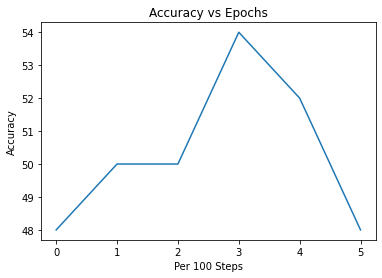

Starting Validation for learning rate:  0.0001
Step 25. For the last 24 steps: average loss 0.05772758367618195, accuracy 5
Step 49. For the last 24 steps: average loss 0.057780326179303974, accuracy 7
Step 73. For the last 24 steps: average loss 0.05775245223007938, accuracy 7
Step 97. For the last 24 steps: average loss 0.057760124054042315, accuracy 7
Step 121. For the last 24 steps: average loss 0.05768860382128415, accuracy 27
Step 145. For the last 24 steps: average loss 0.05772264310947262, accuracy 46


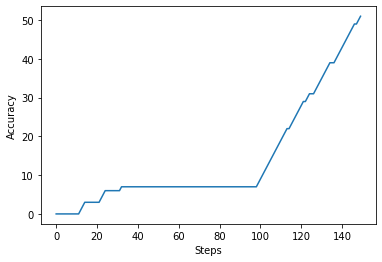

No handles with labels found to put in legend.


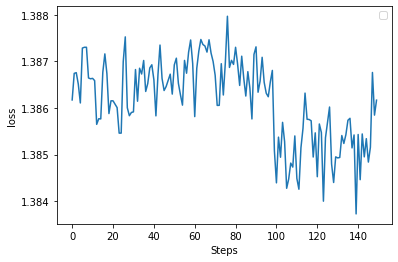

Starting Training for learning rate:  0.001
Epoch 1 ->
Step 101. For the last 100 steps: average loss 1.334120775629676, accuracy 37
Step 201. For the last 100 steps: average loss 1.2679451345398725, accuracy 39
Step 301. For the last 100 steps: average loss 1.209033906590492, accuracy 40
Step 401. For the last 100 steps: average loss 1.2484889732795272, accuracy 40
Step 501. For the last 100 steps: average loss 1.2367617020803137, accuracy 43
Step 601. For the last 100 steps: average loss 1.1573071727859645, accuracy 51


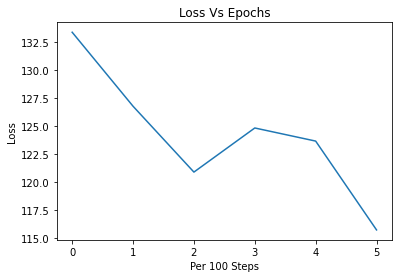

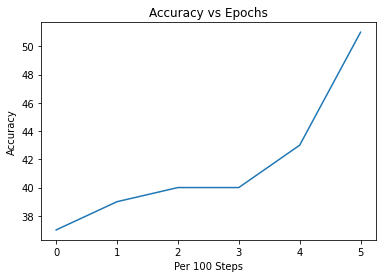

Epoch 2 ->
Step 101. For the last 100 steps: average loss 1.130059866948304, accuracy 52
Step 201. For the last 100 steps: average loss 1.110834495716547, accuracy 55
Step 301. For the last 100 steps: average loss 1.094003116365125, accuracy 48
Step 401. For the last 100 steps: average loss 0.9994260826128649, accuracy 54
Step 501. For the last 100 steps: average loss 1.015610174115229, accuracy 53
Step 601. For the last 100 steps: average loss 1.0887908265755533, accuracy 54


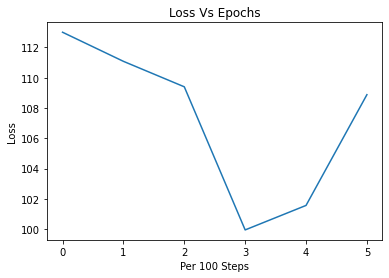

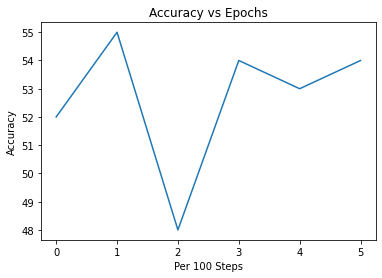

Epoch 3 ->
Step 101. For the last 100 steps: average loss 0.9667165536176553, accuracy 55
Step 201. For the last 100 steps: average loss 0.9823349698471056, accuracy 55
Step 301. For the last 100 steps: average loss 0.9974637654682419, accuracy 62
Step 401. For the last 100 steps: average loss 0.9724792828621659, accuracy 67
Step 501. For the last 100 steps: average loss 0.9116647200746829, accuracy 69
Step 601. For the last 100 steps: average loss 0.9919146860807776, accuracy 54


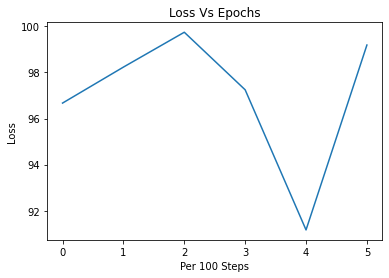

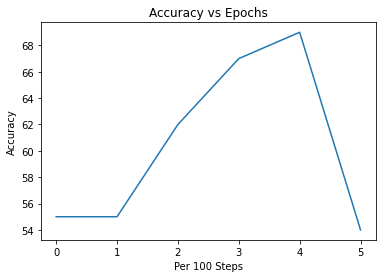

Epoch 4 ->
Step 101. For the last 100 steps: average loss 0.9653687509945499, accuracy 65
Step 201. For the last 100 steps: average loss 0.887682516323887, accuracy 67
Step 301. For the last 100 steps: average loss 0.9319875316882869, accuracy 63
Step 401. For the last 100 steps: average loss 0.9445411491983603, accuracy 62
Step 501. For the last 100 steps: average loss 0.851659427984441, accuracy 68
Step 601. For the last 100 steps: average loss 0.9799337185433622, accuracy 62


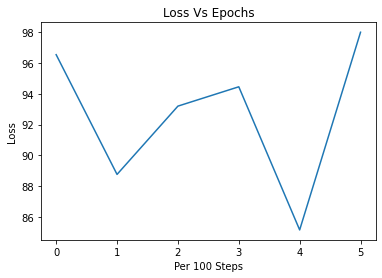

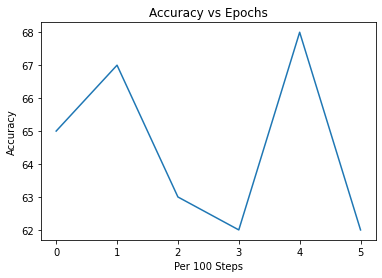

Starting Validation for learning rate:  0.001
Step 25. For the last 24 steps: average loss 0.057822499602496615, accuracy 0
Step 49. For the last 24 steps: average loss 0.057781174951306365, accuracy 0
Step 73. For the last 24 steps: average loss 0.057705957140376934, accuracy 1
Step 97. For the last 24 steps: average loss 0.05773182868816542, accuracy 12
Step 121. For the last 24 steps: average loss 0.05775741648019476, accuracy 14
Step 145. For the last 24 steps: average loss 0.057791547893089, accuracy 16


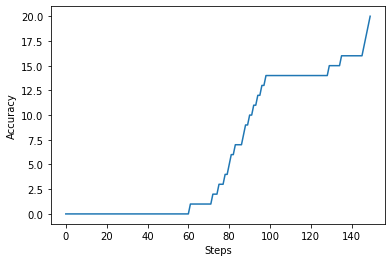

No handles with labels found to put in legend.


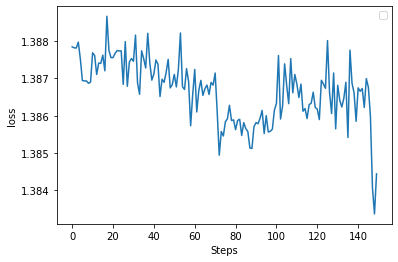

Starting Training for learning rate:  0.01
Epoch 1 ->
Step 101. For the last 100 steps: average loss 2.7126475510741495, accuracy 33
Step 201. For the last 100 steps: average loss 2.781845347088244, accuracy 31
Step 301. For the last 100 steps: average loss 2.0790104344130333, accuracy 52
Step 401. For the last 100 steps: average loss 2.1458724228180075, accuracy 45
Step 501. For the last 100 steps: average loss 2.2539131526576583, accuracy 42
Step 601. For the last 100 steps: average loss 1.9208056009183974, accuracy 53


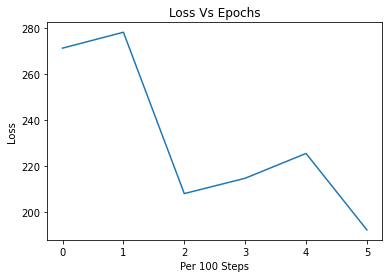

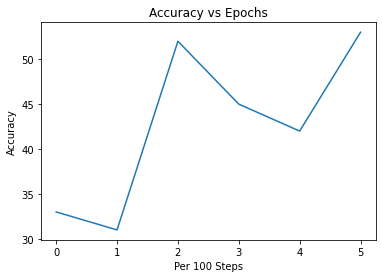

Epoch 2 ->
Step 101. For the last 100 steps: average loss 1.3108923856718238, accuracy 60
Step 201. For the last 100 steps: average loss 1.3827576841274736, accuracy 58
Step 301. For the last 100 steps: average loss 1.5545055453144476, accuracy 58
Step 401. For the last 100 steps: average loss 1.3858236503814707, accuracy 56
Step 501. For the last 100 steps: average loss 1.3061549255432183, accuracy 63
Step 601. For the last 100 steps: average loss 1.108634045999283, accuracy 67


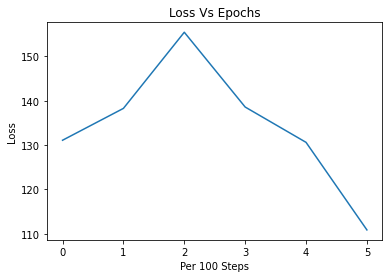

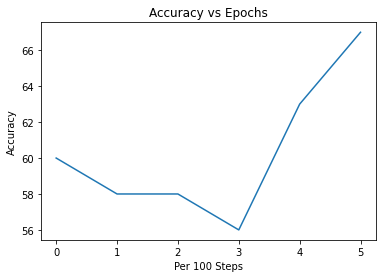

Epoch 3 ->
Step 101. For the last 100 steps: average loss 1.0188776037555758, accuracy 63
Step 201. For the last 100 steps: average loss 1.2351281967595935, accuracy 63
Step 301. For the last 100 steps: average loss 0.9961902528291724, accuracy 64
Step 401. For the last 100 steps: average loss 0.8889961072830002, accuracy 73
Step 501. For the last 100 steps: average loss 1.2275652398757682, accuracy 67
Step 601. For the last 100 steps: average loss 1.197577113523375, accuracy 64


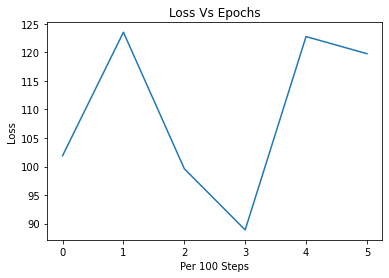

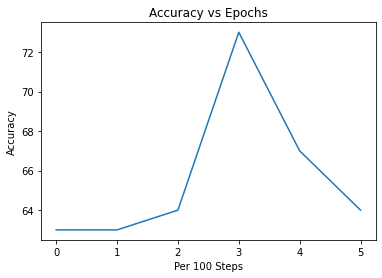

Epoch 4 ->
Step 101. For the last 100 steps: average loss 0.9345250391337168, accuracy 71
Step 201. For the last 100 steps: average loss 0.9075645681587114, accuracy 73
Step 301. For the last 100 steps: average loss 1.1775112675046462, accuracy 70
Step 401. For the last 100 steps: average loss 0.7602941289000309, accuracy 73
Step 501. For the last 100 steps: average loss 0.6855648861587429, accuracy 72
Step 601. For the last 100 steps: average loss 0.8789269458272077, accuracy 71


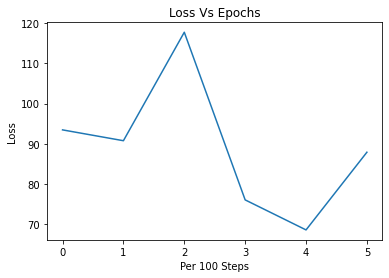

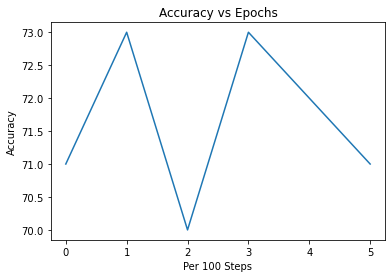

Starting Validation for learning rate:  0.01
Step 25. For the last 24 steps: average loss 0.05779264722999497, accuracy 4
Step 49. For the last 24 steps: average loss 0.05775590923232137, accuracy 9
Step 73. For the last 24 steps: average loss 0.057712693623577234, accuracy 13
Step 97. For the last 24 steps: average loss 0.057720421367261986, accuracy 32
Step 121. For the last 24 steps: average loss 0.057771220327681394, accuracy 40
Step 145. For the last 24 steps: average loss 0.05774597265612478, accuracy 44


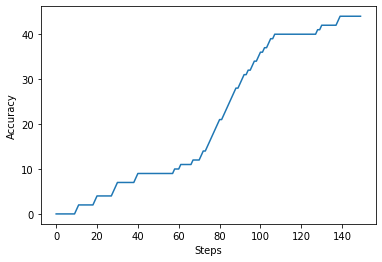

No handles with labels found to put in legend.


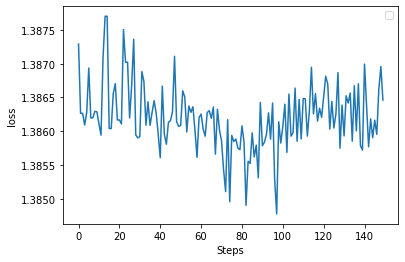

Starting Training for learning rate:  0.1
Epoch 1 ->
Step 101. For the last 100 steps: average loss 15.389115639876072, accuracy 28
Step 201. For the last 100 steps: average loss 9.696659460853544, accuracy 51
Step 301. For the last 100 steps: average loss 13.591153757177288, accuracy 44
Step 401. For the last 100 steps: average loss 11.334010455013528, accuracy 61
Step 501. For the last 100 steps: average loss 22.656568669882276, accuracy 35
Step 601. For the last 100 steps: average loss 25.91589607638312, accuracy 43


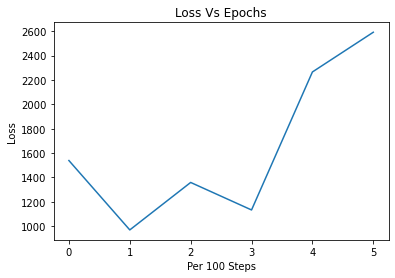

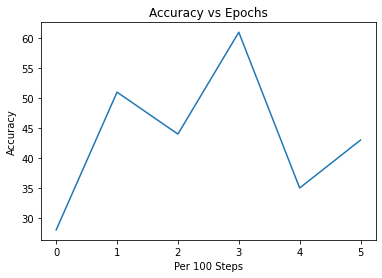

Epoch 2 ->
Step 101. For the last 100 steps: average loss 18.68211272958411, accuracy 58
Step 201. For the last 100 steps: average loss 23.481849779490886, accuracy 50
Step 301. For the last 100 steps: average loss 26.283465353714124, accuracy 48
Step 401. For the last 100 steps: average loss 27.270511904196105, accuracy 52
Step 501. For the last 100 steps: average loss 12.942615988087386, accuracy 63
Step 601. For the last 100 steps: average loss 20.004049899775897, accuracy 59


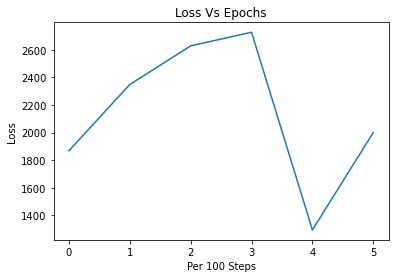

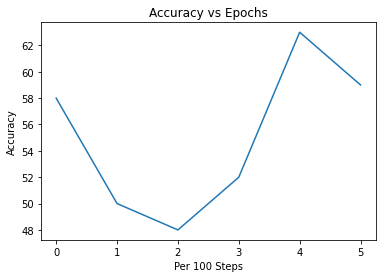

Epoch 3 ->
Step 101. For the last 100 steps: average loss 23.401600444752145, accuracy 57
Step 201. For the last 100 steps: average loss 27.115355894932655, accuracy 58
Step 301. For the last 100 steps: average loss 16.654061976224884, accuracy 61
Step 401. For the last 100 steps: average loss 17.492273825268803, accuracy 63
Step 501. For the last 100 steps: average loss 18.466962466576984, accuracy 55
Step 601. For the last 100 steps: average loss 9.565106758468131, accuracy 66


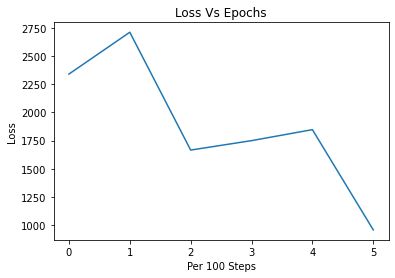

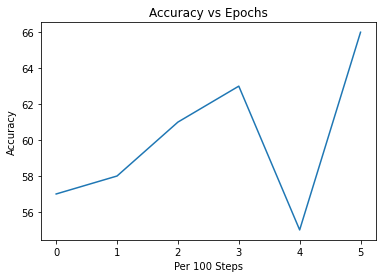

Epoch 4 ->
Step 101. For the last 100 steps: average loss 7.752873350101275, accuracy 71
Step 201. For the last 100 steps: average loss 5.322222086024797, accuracy 76
Step 301. For the last 100 steps: average loss 5.2358629241936185, accuracy 78
Step 401. For the last 100 steps: average loss 8.568686642630091, accuracy 75
Step 501. For the last 100 steps: average loss 8.087555261397855, accuracy 72
Step 601. For the last 100 steps: average loss 9.364503028813733, accuracy 70


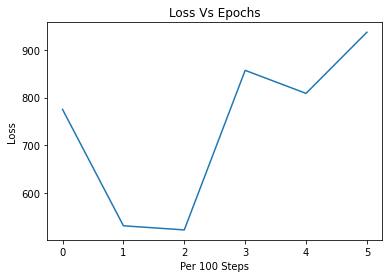

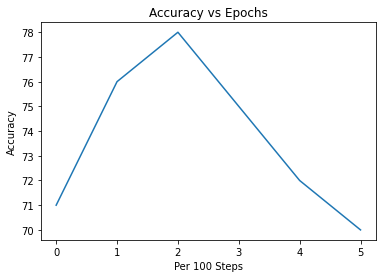

Starting Validation for learning rate:  0.1
Step 25. For the last 24 steps: average loss 0.057746449197846446, accuracy 0
Step 49. For the last 24 steps: average loss 0.0577336294053099, accuracy 6
Step 73. For the last 24 steps: average loss 0.05780108054347754, accuracy 13
Step 97. For the last 24 steps: average loss 0.05778755538857013, accuracy 13
Step 121. For the last 24 steps: average loss 0.057738977910323945, accuracy 27
Step 145. For the last 24 steps: average loss 0.05775510618463242, accuracy 38


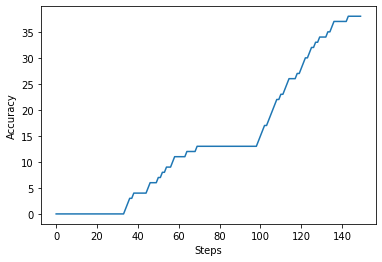

No handles with labels found to put in legend.


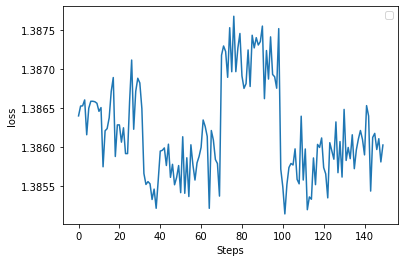

In [ ]:
alpha_list = [0.0001, 0.001, 0.01, 0.1]

for alpha in alpha_list:
    validate_cnn(alpha)

Starting Training for learning rate:  0.01
Epoch 1 ->
Step 101. For the last 100 steps: average loss 1.995246752395889, accuracy 35
Step 201. For the last 100 steps: average loss 2.031157889658752, accuracy 31
Step 301. For the last 100 steps: average loss 1.8599862903021789, accuracy 33
Step 401. For the last 100 steps: average loss 1.4753035667055252, accuracy 53
Step 501. For the last 100 steps: average loss 1.2299212689450763, accuracy 58
Step 601. For the last 100 steps: average loss 1.457284439583322, accuracy 51


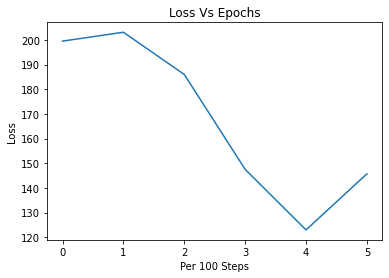

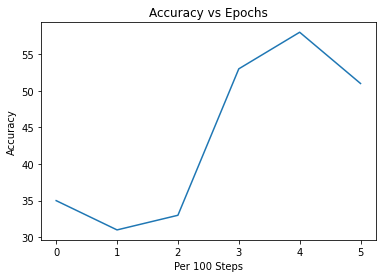

Epoch 2 ->
Step 101. For the last 100 steps: average loss 1.0569659137141472, accuracy 54
Step 201. For the last 100 steps: average loss 1.2150716815179567, accuracy 57
Step 301. For the last 100 steps: average loss 1.194093760237867, accuracy 58
Step 401. For the last 100 steps: average loss 1.2794515974079588, accuracy 58
Step 501. For the last 100 steps: average loss 1.2827022315464205, accuracy 57
Step 601. For the last 100 steps: average loss 1.0045649572567221, accuracy 67


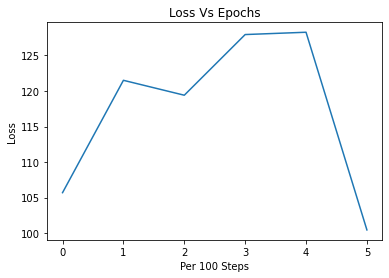

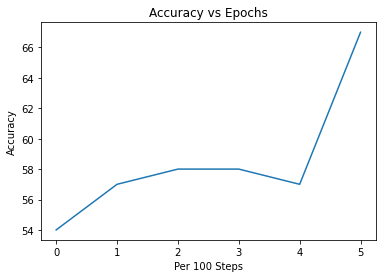

Epoch 3 ->
Step 101. For the last 100 steps: average loss 0.9312343023267121, accuracy 70
Step 201. For the last 100 steps: average loss 0.713975892577288, accuracy 78
Step 301. For the last 100 steps: average loss 0.8890852333466781, accuracy 70
Step 401. For the last 100 steps: average loss 1.0065201496798712, accuracy 61
Step 501. For the last 100 steps: average loss 0.9415454297343804, accuracy 68
Step 601. For the last 100 steps: average loss 0.8177437190005518, accuracy 64


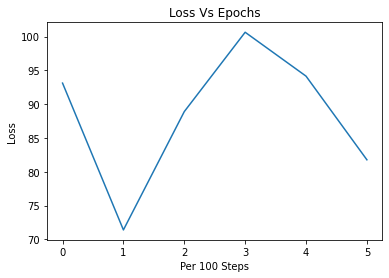

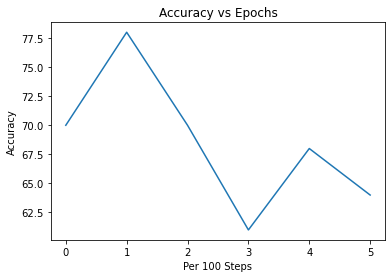

Epoch 4 ->
Step 101. For the last 100 steps: average loss 0.650684968668848, accuracy 69
Step 201. For the last 100 steps: average loss 0.5656050890722305, accuracy 80
Step 301. For the last 100 steps: average loss 0.783397936113684, accuracy 75
Step 401. For the last 100 steps: average loss 0.621782879999803, accuracy 79
Step 501. For the last 100 steps: average loss 0.7173681165550255, accuracy 72
Step 601. For the last 100 steps: average loss 0.5991772547238058, accuracy 75


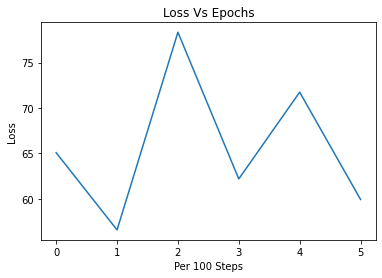

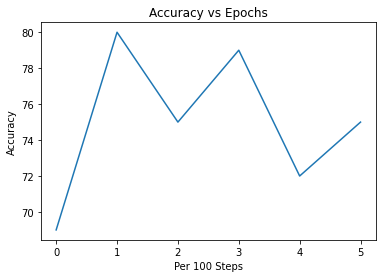

In [ ]:
layers = [
ConvolutionLayer(16,3), # layer with 16 3x3 filters, output (62,62,16)
MaxPoolingLayer(2), # pooling layer 2x2, output (31,31,16)
SoftmaxLayer(31*31*16, 4) # softmax layer with 31*31*16 input and 4 outputs
] 
accuracy = 0
test_loss = []
test_acc = []

train_main_method(0.01)

for i, (image, label) in enumerate(zip(testX, testY)):
    label = label[0]
    image = image.reshape(64,64)
    _ , loss, acc = CNN_forward(image, label, layers)
    
    test_loss.append(loss)
    accuracy += acc
    test_acc.append(accuracy)

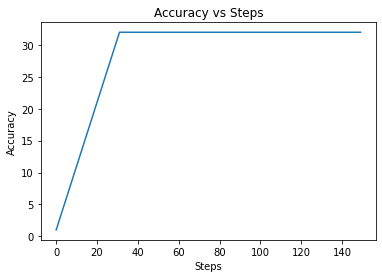

In [ ]:
plt.figure()
plt.xlabel("Steps")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Steps")
plt.plot(test_acc)
plt.show()

In [ ]:
print("The final testing accuracy is: ", test_acc[-1])

The final testing accuracy is:  32


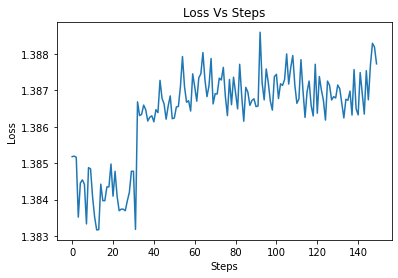

In [ ]:
plt.figure
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Loss Vs Steps")
plt.plot(test_loss)
plt.show()